# Advanced Lane Finding
[![Udacity - Self-Driving Car NanoDegree](https://s3.amazonaws.com/udacity-sdc/github/shield-carnd.svg)](http://www.udacity.com/drive)

In this project, your goal is to write a software pipeline to identify the lane boundaries in a video. This Jupyter Notebook is for documenting the code to achieve the required lane detection through the following steps:
* Camera Calibration
* Distortion Correction
* Color & Gradient Threshold
* Perspective Transformation
* Detect Lane Lines
* Determine the lane curvature

## Camera Calibration

In [1]:
#import necessary modules
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
from glob import glob
from moviepy.editor import VideoFileClip

In [2]:
""" 
Routine for Calibrating a Camera using OpenCV Library
functions such as:
    - Chessboards
    - undistort
"""
# 22.09.19   vka   initial version

# ---- CAMERA CALIBRATION ----
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        write_name = 'corners_found'+str(idx)+'.jpg'
        cv2.imwrite('output_images/'+write_name, img)
        cv2.imshow('img', img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

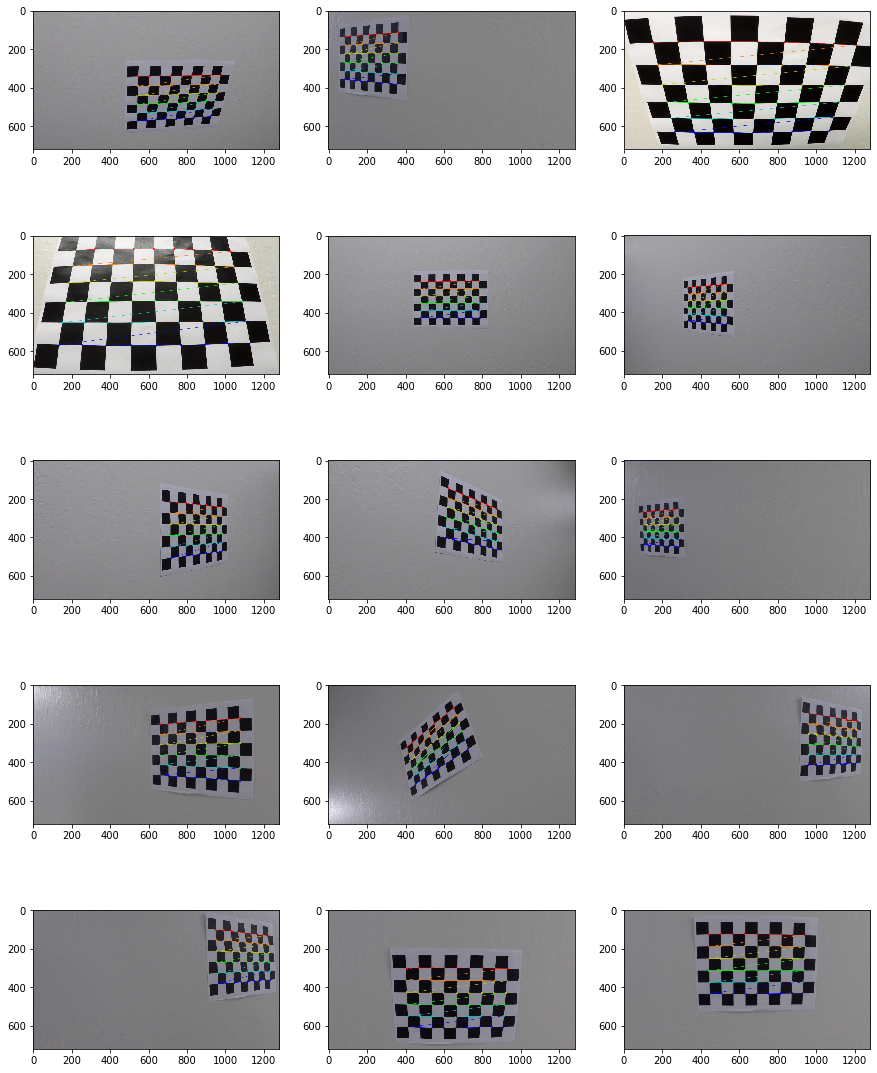

In [5]:
def show_images(images,columns=3,cmap='gray',imgsize=(15,20)):
    #Display only two images per row
    rows = len(images)//columns
    plt.figure(figsize = imgsize)
    for i,image in enumerate(images):
        plt.subplot(rows,columns,i+1)
        plt.imshow(image,cmap = cmap)
    plt.show()

camera_calibration = [plt.imread(path) for path in glob('output_images/corners_found*.jpg')]
show_images (camera_calibration)

## Distortion Correction

Text(0.5, 1.0, 'Undistorted Image')

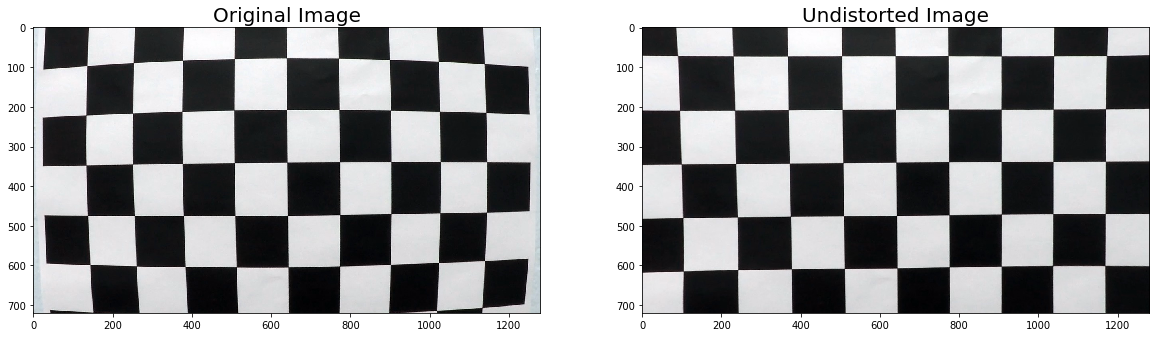

In [6]:
# Test undistortion on an Chessboard image
img = cv2.imread('camera_cal/test_image.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('output_images/test_image_undistort.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_cal/wide_dist_pickle.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=20)

## Distorting Correction on a Regular Image

We test the distortion correction on a regular image to check the effectiveness of the radial distortion correction.

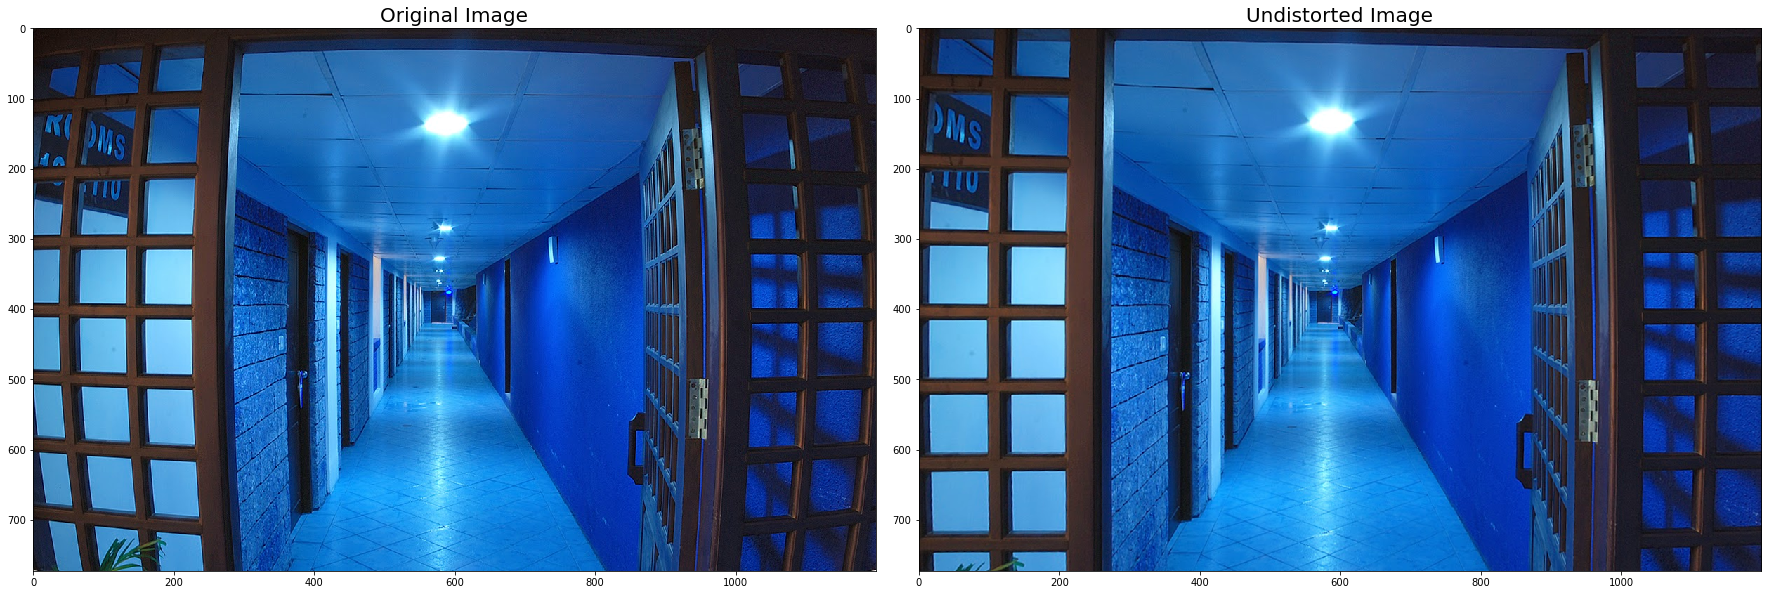

In [7]:
# Read in an image
img = cv2.imread('camera_cal/test_image_2.jpg')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints,imgpoints,gray.shape[::-1],None, None)
    undist = cv2.undistort(img,mtx,dist,None,mtx)
    return undist

undistorted = cal_undistort(img, objpoints, imgpoints)
cv2.imwrite('output_images/test_image_2_undistort.jpg',undistorted)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Distorting Correction on Traffic Images

In [8]:
# Define a function for Distortion Correction, based on the tests performed above
def undistort(img, show = True):
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    if show:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,9))
        ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax1.set_title('Original Image', fontsize=20)
        ax2.imshow(cv2.cvtColor(undist, cv2.COLOR_BGR2RGB))
        ax2.set_title('Undistorted Image', fontsize=20)
    return undist

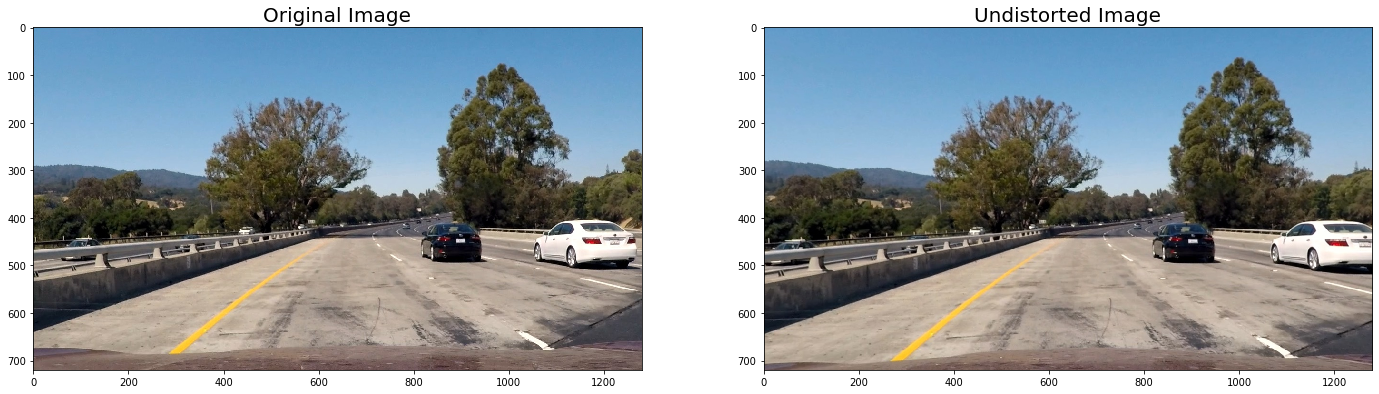

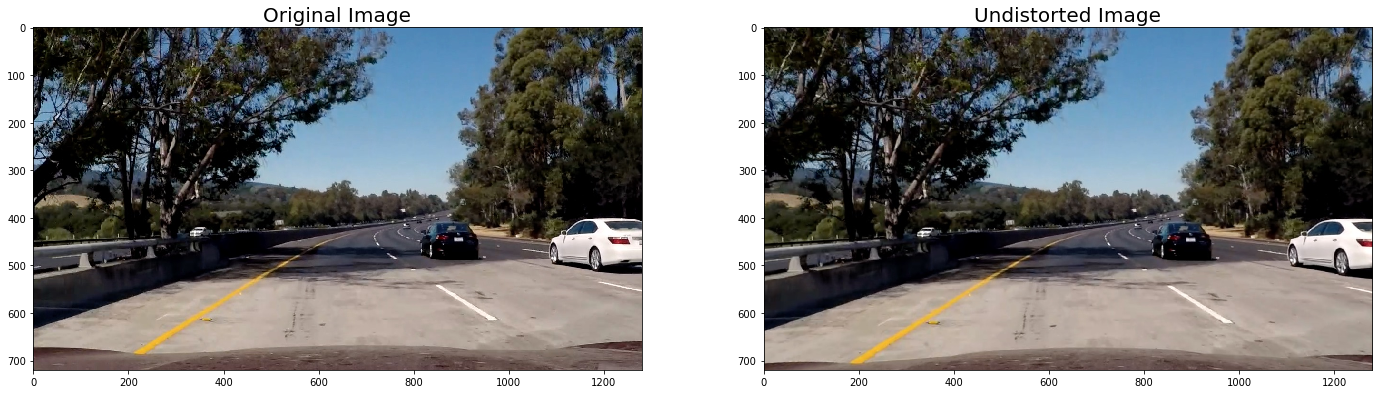

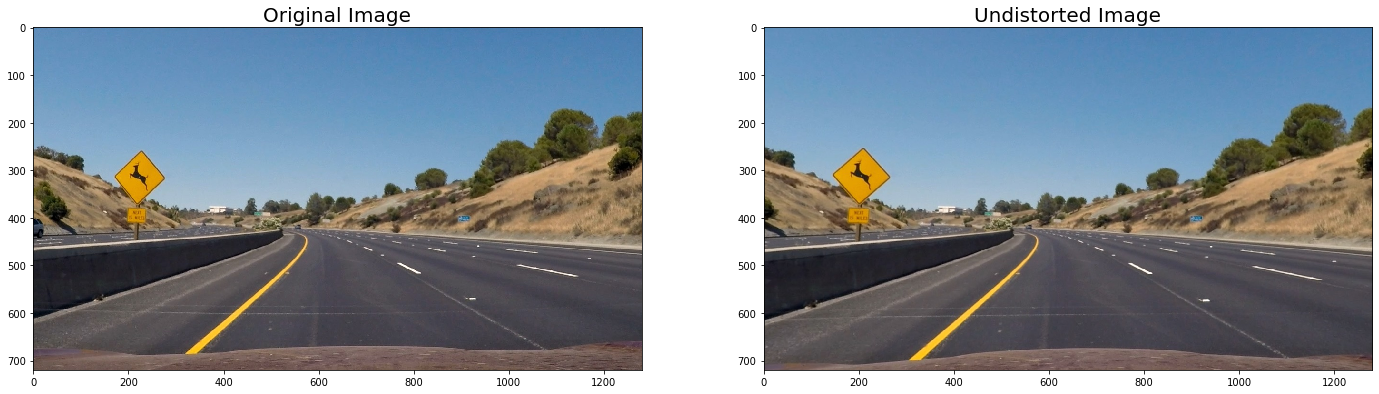

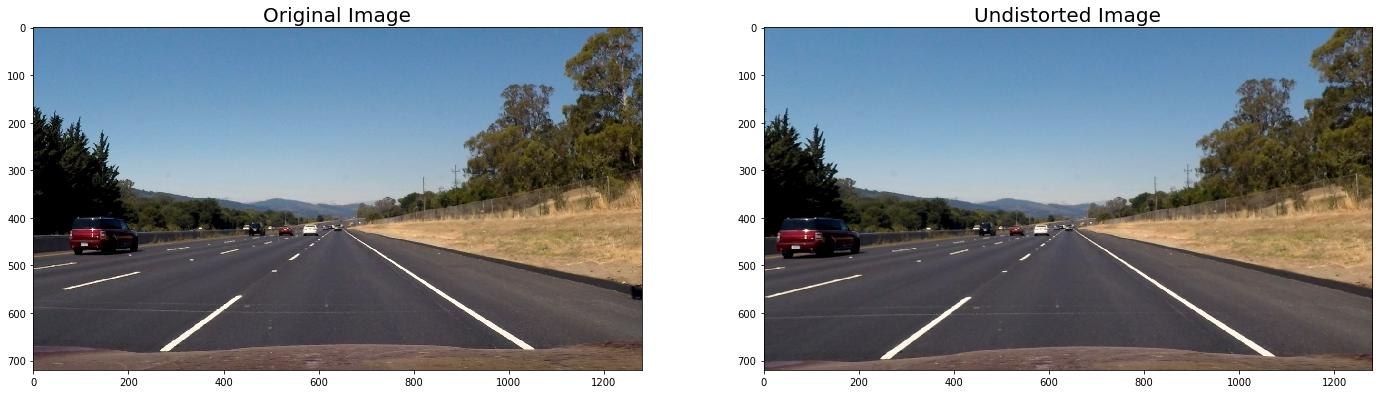

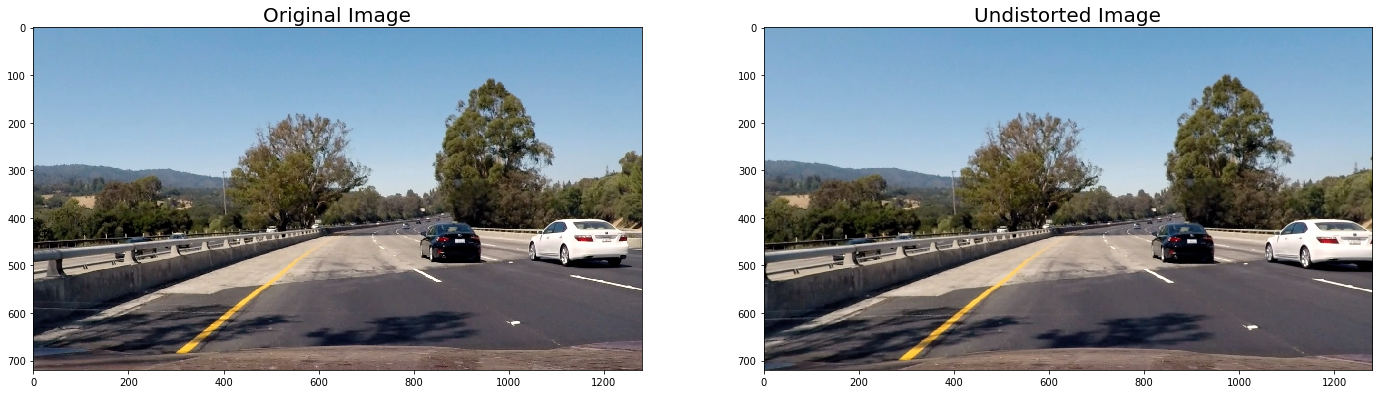

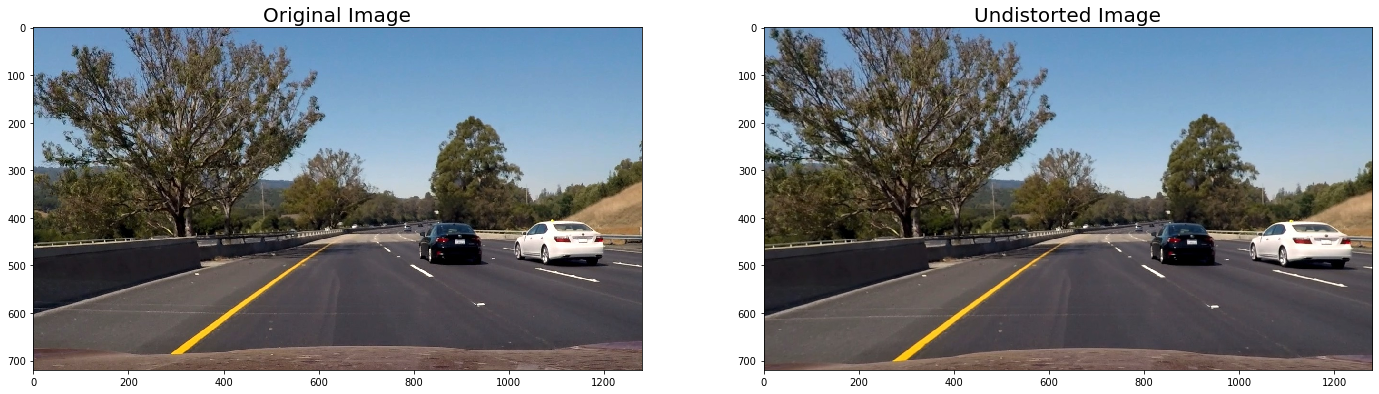

In [9]:
# Make a list of test images
images = glob('test_images/test*.jpg')
for idx, fname in enumerate(images):
    image = cv2.imread(fname)
    image_undistorted = undistort(image)
    write_name = 'undistorted'+str(idx)+'.jpg'
    cv2.imwrite('output_images/'+write_name, image_undistorted)

## Color & Gradient Threshold

In [10]:
def threshold(img, s_thresh=(80, 255), sx_thresh=(10, 255), l_thresh=(90,255),display=False):
    img = np.copy(img)
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    # Convert to HLS color space and separate the S channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Threshold color S-channel for getting color saturation of lane lines
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Threshold color L-Channel for lighting and filtering out the dark spots in the image
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    
    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1

    # Direction of Gradient threshold using inverse Tangent
    sobel_x = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize = 3)
    sobel_y = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize = 3)
    abs_sobel_x = np.absolute(sobel_x)
    abs_sobel_y = np.absolute(sobel_y)
    direction = np.arctan2(abs_sobel_y,abs_sobel_x) #arctan(sobely/sobelx)
    direction = np.absolute(direction)
    #  Threshold direction to extract near vertical lines
    dirbinary = np.zeros_like(direction)
    dirbinary[(direction >=0) & (direction <=np.pi/2)] = 1
    dirbinary = np.uint8(dirbinary)
    # Stack each channel
    #color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    color_binary = np.zeros_like(dirbinary)
    color_binary = np.bitwise_and(l_binary,np.bitwise_and(s_binary,dirbinary))*255
    if display:
        #Display the thresholded images
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 6))
        f.tight_layout()
        ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax1.set_title('Undistorted Image', fontsize=20)
        ax2.imshow(cv2.cvtColor(color_binary, cv2.COLOR_BGR2RGB))
        ax2.set_title('Threshold Image', fontsize=20)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)    
    
    return color_binary
    

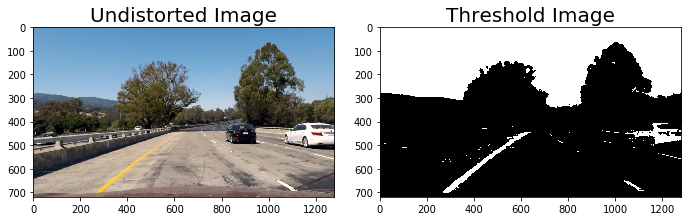

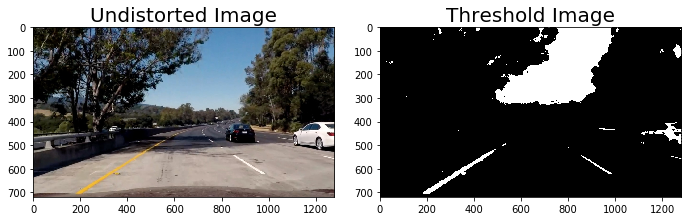

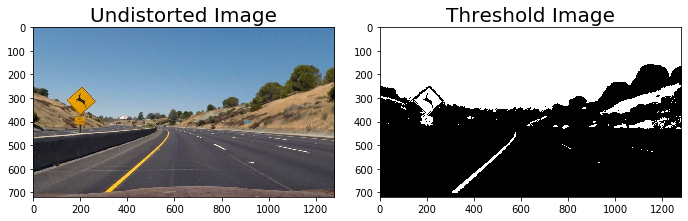

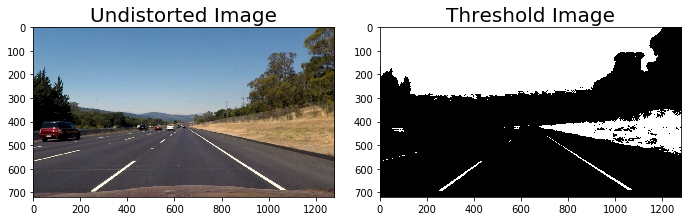

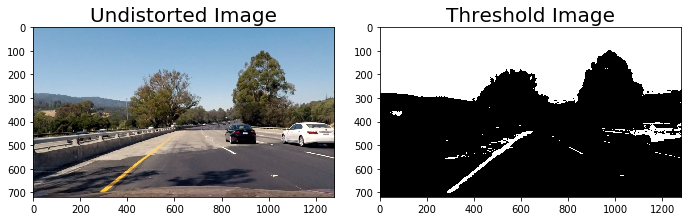

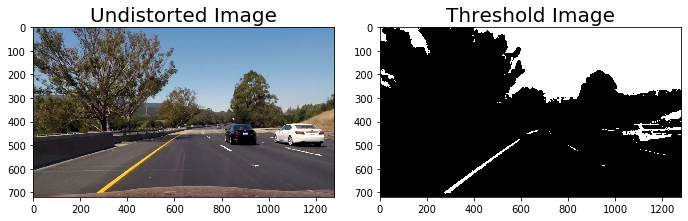

In [11]:
# Make a list of undistorted images
images = glob('output_images/undistorted*.jpg')
for idx, fname in enumerate(images):
    image = cv2.imread(fname)
    image_threshold = threshold(image,display=True)
    write_name = 'threshold'+str(idx)+'.jpg'
    cv2.imwrite('output_images/'+write_name, image_threshold)

## Perceptive Transformation

In [12]:
# Perform perspective transform
def birds_eye(img, display=False):

    img_size = (img.shape[1], img.shape[0])
    offset = 0
    # Vertices extracted manually for performing a perspective transform
    bottom_left = [40, 720]
    bottom_right = [1250, 720]
    top_left = [490, 482]
    top_right = [810, 482]
    source = np.float32([top_left,top_right,bottom_right,bottom_left])

    pts = np.array([bottom_left,bottom_right,top_right,top_left], np.int32)
    pts = pts.reshape((-1,1,2))
    copy = img.copy()
    cv2.polylines(copy,[pts],True,(255,0,0), thickness=3)

    # Destination points are chosen such that straight lanes appear more or less parallel in the transformed image.
    bottom_left = [40,720]
    bottom_right = [1250, 720]
    top_left = [0, 0]
    top_right = [1280, 0]
    dst = np.float32([top_left,top_right,bottom_right,bottom_left])
    M = cv2.getPerspectiveTransform(source, dst)
    warped = cv2.warpPerspective(img, M, img_size)
    if display:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 6))
        f.tight_layout()
        ax1.imshow(cv2.cvtColor(copy, cv2.COLOR_BGR2RGB))
        ax1.set_title('Threshold Image', fontsize=20)
        ax2.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
        ax2.set_title('Warped Image', fontsize=20)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

    return warped

In [13]:
# Make a list of threshold images
images = glob('output_images/threshold*.jpg')
for idx, fname in enumerate(images):
    image = cv2.imread(fname)
    image_warp = birds_eye(image)
    write_name = 'warp'+str(idx)+'.jpg'
    cv2.imwrite('output_images/'+write_name, image_warp)

## Detect Lane Lines

### Creating Histogram

In [ ]:
def hist(img, display = False):
    # Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = img[img.shape[0]//100:,:]

    # Sum across image pixels vertically - make sure to set an `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half, axis=0)
    
    if display:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 6))
        f.tight_layout()
        ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax1.set_title('Warped Image', fontsize=20)
        ax2.plot(histogram)
        ax2.set_title('Image Histogram', fontsize=20)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
    return histogram

# Make a list of threshold images
images = glob('output_images/warp*.jpg')
for idx, fname in enumerate(images):
    image = cv2.imread(fname)
    image_hist = hist(image, display = True)


### Slide Window search

In [ ]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 10
    # Set the width of the windows +/- margin
    margin = 50
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))


    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped, display=False):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    
    for point in range(len(ploty[:-1])):
        cv2.line(out_img,(int(left_fitx[point]),int(ploty[point])),(int(left_fitx[point+1]),int(ploty[point+1])),(125, 125, 125),5)
        cv2.line(out_img,(int(right_fitx[point]),int(ploty[point])),(int(right_fitx[point+1]),int(ploty[point+1])),(125, 125, 125),5)
    #cv2.line(out_img, start_point, end_point, color, thickness) 

    if display:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()
        ax1.imshow(cv2.cvtColor(binary_warped, cv2.COLOR_BGR2RGB))
        ax1.set_title('Warped Image', fontsize=20)
        ax2.imshow(cv2.cvtColor(out_img, cv2.COLOR_BGR2RGB))
        ax2.set_title('Windows and Lanes', fontsize=20)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)    
    
    return out_img

In [ ]:
# Make a list of threshold images
images = glob('output_images/warp*.jpg')
for idx, fname in enumerate(images):
    image = cv2.imread(fname,0)
    image_windowsearch = fit_polynomial(image,display=True)
    write_name = 'windowsearch'+str(idx)+'.jpg'
    cv2.imwrite('output_images/'+write_name, image_windowsearch)

### Identify lane around previously detected line and Inverse Transform

In [ ]:
def measure_radius_of_curvature(x_values,y_points):
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # If no pixels were found return None
    y_eval = np.max(y_points)
    # Fit new polynomials to x,y in world space
    fit_cr = np.polyfit(y_points*ym_per_pix, x_values*xm_per_pix, 2)
    curverad = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
    return curverad

def fit_poly(img_shape, leftx, lefty, rightx, righty):
     ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped,original,display=False):
    
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
    
    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 50

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    for point in range(len(ploty[:-1])):
        cv2.line(result,(int(left_fitx[point]),int(ploty[point])),(int(left_fitx[point+1]),int(ploty[point+1])),(125, 125, 125),5)
        cv2.line(result,(int(right_fitx[point]),int(ploty[point])),(int(right_fitx[point+1]),int(ploty[point+1])),(125, 125, 125),5)
    #cv2.line(out_img, start_point, end_point, color, thickness)
    
    # Inverse Transform
    bottom_left = [40, 720]
    bottom_right = [1250, 720]
    top_left = [490, 482]
    top_right = [810, 482]
    source = np.float32([top_left,top_right,bottom_right,bottom_left])
    # Destination points are chosen such that straight lanes appear more or less parallel in the transformed image.
    bottom_left = [40,720]
    bottom_right = [1250, 720]
    top_left = [0, 0]
    top_right = [1280, 0]
    dst = np.float32([top_left,top_right,bottom_right,bottom_left])    
    Minv = cv2.getPerspectiveTransform(dst, source)
    
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    pts_left = np.array([np.flipud(np.transpose(np.vstack([left_fitx, ploty])))])
    pts_right = np.array([np.transpose(np.vstack([right_fitx, ploty]))])
    pts = np.hstack((pts_left, pts_right))
    cv2.polylines(color_warp, np.int_([pts]), isClosed=False, color=(0,0,255), thickness = 40)
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    newwarp = cv2.warpPerspective(color_warp, Minv, (binary_warped.shape[1], binary_warped.shape[0]))
    graphic = cv2.addWeighted(original, 1, newwarp, 0.5, 0)
    
    # Calculate the Radius of curvature and center offset
    left_curverad = measure_radius_of_curvature(left_fitx,ploty)
    right_curverad = measure_radius_of_curvature(right_fitx,ploty)
    cv2.putText(graphic, 'Radius of curvature is {}m'.format(int((left_curverad + right_curverad)/2)), (50, 50), cv2.FONT_HERSHEY_SIMPLEX,1, (255, 255, 0), 2, cv2.LINE_AA)

    # Calculate the center offset
    lane_center = (right_fitx[719] + left_fitx[719])/2
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    center_offset_pixels = abs(binary_warped.shape[0]/2 - lane_center)
    center_offset_mtrs = xm_per_pix*center_offset_pixels
    cv2.putText(graphic, 'Center offset is {}m'.format(round(center_offset_mtrs,2)), (50, 100), cv2.FONT_HERSHEY_SIMPLEX,1, (255, 255, 0), 2, cv2.LINE_AA)
    
    if display:
        f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(24, 9))
        f.tight_layout()
        ax1.imshow(cv2.cvtColor(binary_warped, cv2.COLOR_BGR2RGB))
        ax1.set_title('Warped Image', fontsize=20)
        ax2.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
        ax2.set_title('Windows and Lanes', fontsize=20)
        ax3.imshow(cv2.cvtColor(graphic, cv2.COLOR_BGR2RGB))
        ax3.set_title('Transformed', fontsize=20)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.) 
    
    return result,graphic


In [ ]:
# Make a list of warped images
images = glob('output_images/warp*.jpg')
for idx, fname in enumerate(images):
    image = cv2.imread(fname,0)
    undistorted = fname.replace("warp", "undistorted")
    original = cv2.imread(undistorted)
    image_aroundpoly = search_around_poly(image,original,display=True)
    write_name = 'polysearch'+str(idx)+'.jpg'
    cv2.imwrite('output_images/'+write_name, image_aroundpoly[0])
    write_name = 'final'+str(idx)+'.jpg'
    cv2.imwrite('output_images/'+write_name, image_aroundpoly[1])

## Video Processing

In [ ]:
def get_linecoordinates(binary_warped, display=False):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
        
    left_x_intcep = [left_fitx[0],fit_x[binary_warped.shape[0]-1]]
    right_x_intcep = [right_fitx[0],fit_x[binary_warped.shape[0]-1]]
    
    return left_fitx,right_fitx, left_x_intcep,right_x_intcep

In [ ]:
def get_averaged_line(previous_lines, new_line):
    """
        This function computes an averaged lane line by averaging over previous good frames.
    """
    
    # Number of frames to average over
    num_frames = 12
    
    if new_line is None:
        # No line was detected
        
        if len(previous_lines) == 0:
            # If there are no previous lines, return None
            return previous_lines, None
        else:
            # Else return the last line
            return previous_lines, previous_lines[-1]
    else:
        if len(previous_lines) < num_frames:
            # we need at least num_frames frames to average over
            previous_lines.append(new_line)
            return previous_lines, new_line
        else:
            # average over the last num_frames frames
            previous_lines[0:num_frames-1] = previous_lines[1:]
            previous_lines[num_frames-1] = new_line
            new_line = np.zeros_like(new_line)
            for i in range(num_frames):
                new_line += previous_lines[i]
            new_line /= num_frames
            return previous_lines, new_line
        
def get_mean_difference_between_lines(left_line, right_line, running_average):
    """
        Returns running weighted average of simple difference between left and right lines
    """
    mean_distance = np.mean(right_line - left_line)
    if running_average == 0:
        running_average = mean_distance
    else:
        running_average = 0.9*running_average + 0.1*mean_distance
    return running_average


def get_line_predictions(non_zeros_x, non_zeros_y, left_coordinates, right_coordinates, num_rows):
    """
        Given ncoordinates of non-zeros pixels and coordinates of non-zeros pixels within the sliding windows,
        this function generates a prediction for the lane line.
    """
    left_x = non_zeros_x[left_coordinates]
    left_y = non_zeros_y[left_coordinates]
    
    # If no pixels were found return None
    if(left_y.size == 0 or left_x.size == 0):
        return None, None

    # Fit the polynomial
    polyfit_left = np.polyfit(left_y, left_x, 2)

    right_x = non_zeros_x[right_coordinates]
    right_y = non_zeros_y[right_coordinates]
    
    # If no pixels were found return None
    if(right_y.size == 0 or right_x.size == 0):
        return None, None

    # Fit the polynomial
    polyfit_right = np.polyfit(right_y, right_x, 2)

    # If no pixels were found return None
    y_points = np.linspace(0, num_rows-1, num_rows)
    
    # Generate the lane lines from the polynomial fit
    left_x_predictions = polyfit_left[0]*y_points**2 + polyfit_left[1]*y_points + polyfit_left[2]
    right_x_predictions = polyfit_right[0]*y_points**2 + polyfit_right[1]*y_points + polyfit_right[2]
    
    return left_x_predictions, right_x_predictions

In [ ]:
def pipeline_final(img):
    # global variables to store the polynomial coefficients of the line detected in the last frame
    global polyfit_right
    global polyfit_left
    
    # global variables to store the line coordinates in previous n (=4) frames
    global past_good_right_lines
    global past_good_left_lines
    
    # global variable which contains running average of the mean difference between left and right lanes
    global running_mean_difference_between_lines
    
    img_shape = img.shape
    img_size = (img_shape[1], img_shape[0])
    
    # get thresholded image
    threshold_video = threshold(img)
    
    # perform a perspective transform
    warped_video = birds_eye(threshold_video, display=False)

    out_img = np.dstack((warped_video, warped_video, warped_video))*255
    
    non_zeros = warped_video.nonzero()
    non_zeros_y = non_zeros[0]
    non_zeros_x = non_zeros[1]
    
    num_rows = warped_video.shape[0]
    y_points = np.linspace(0, num_rows-1, num_rows)
    
    if (polyfit_left is None) or (polyfit_right is None):
        # If the polynomial coefficients of the previous frames are None then perform a search Reset
        reset = True
        left_x_predictions, right_x_predictions = get_linecoordinates(warped_video)
    else:
        # Else search in a margin of 100 pixels on each side of the pervious polynomial fit
        reset = False
        margin = 100
        left_x_predictions = polyfit_left[0]*non_zeros_y**2 + polyfit_left[1]*non_zeros_y + polyfit_left[2]
        left_coordinates = ((non_zeros_x >= left_x_predictions - margin) & (non_zeros_x <= left_x_predictions + margin)).nonzero()[0]

        right_x_predictions = polyfit_right[0]*non_zeros_y**2 + polyfit_right[1]*non_zeros_y + polyfit_right[2]
        right_coordinates = ((non_zeros_x >= right_x_predictions - margin) & (non_zeros_x <= right_x_predictions + margin)).nonzero()[0]
        
        left_x_predictions, right_x_predictions = get_line_predictions(non_zeros_x, non_zeros_y, left_coordinates, right_coordinates, num_rows)
        
    if (left_x_predictions is None or right_x_predictions is None):
        if not reset:
            left_x_predictions, right_x_predictions = get_linecoordinates(warped_video)
        incorrect_prediction = False
        
    if (left_x_predictions is None or right_x_predictions is None):
        incorrect_prediction = True
    else:
        mean_difference = np.mean(right_x_predictions - left_x_predictions)
        
        if running_mean_difference_between_lines == 0:
            running_mean_difference_between_lines = mean_difference
            #mean_deviation = ((mean_difference < 0.7*running_mean_difference_between_lines) or (mean_difference > 1.3*running_mean_difference_between_lines))
        if ((mean_difference < 0.7*running_mean_difference_between_lines) or (mean_difference > 1.3*running_mean_difference_between_lines)):
            incorrect_prediction = True
            if not reset:
                left_x_predictions, right_x_predictions = get_linecoordinates(warped_video)
                if (left_x_predictions is None or right_x_predictions is None):
                    incorrect_prediction = True
                else:
                    mean_difference = np.mean(right_x_predictions - left_x_predictions)
                    #mean_deviation = ((mean_difference < 0.7*running_mean_difference_between_lines) or (mean_difference > 1.3*running_mean_difference_between_lines))
                    if ((mean_difference < 0.7*running_mean_difference_between_lines) or (mean_difference > 1.3*running_mean_difference_between_lines)):
                        incorrect_prediction = True
                    else:
                        incorrect_prediction = False
        else:
            incorrect_prediction = False
            
    if incorrect_prediction:
        polyfit_left = None
        polyfit_right = None
        if len(past_good_left_lines) == 0 and len(past_good_right_lines) == 0:
            return img
        else:
            left_x_predictions = past_good_left_lines[-1]
            right_x_predictions = past_good_right_lines[-1]
    else:
        past_good_left_lines, left_x_predictions = get_averaged_line(past_good_left_lines, left_x_predictions)
        past_good_right_lines, right_x_predictions = get_averaged_line(past_good_right_lines, right_x_predictions)
        mean_difference = np.mean(right_x_predictions - left_x_predictions)
        running_mean_difference_between_lines = get_mean_difference_between_lines(left_x_predictions,right_x_predictions,running_mean_difference_between_lines)
    
    left_line_window = np.array(np.transpose(np.vstack([left_x_predictions, y_points])))
    right_line_window = np.array(np.flipud(np.transpose(np.vstack([right_x_predictions, y_points]))))
    
    # compute the radius of curvature
    left_curve_rad = measure_radius_of_curvature(left_x_predictions,y_points)
    right_curve_rad = measure_radius_of_curvature(right_x_predictions,y_points)
    average_curve_rad = (left_curve_rad + right_curve_rad)/2
    curvature_string = "Radius of curvature: %.2f m" % average_curve_rad
    
    # compute the offset from the center
    lane_center = (right_x_predictions[num_rows-1] + left_x_predictions[num_rows-1])/2
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    center_offset_pixels = abs(img_size[0]/2 - lane_center)
    center_offset_mtrs = xm_per_pix*center_offset_pixels
    offset_string = "Center offset: %.2f m" % center_offset_mtrs
    
    poly_points = np.vstack([left_line_window, right_line_window])
    cv2.fillPoly(out_img, np.int_([poly_points]), [0,255, 0])
    # Inverse Transform
    bottom_left = [220,720]
    bottom_right = [1110, 720]
    top_left = [570, 470]
    top_right = [722, 470]
    source = np.float32([top_left,top_right,bottom_right,bottom_left])
    # Destination points are chosen such that straight lanes appear more or less parallel in the transformed image.
    bottom_left = [320,720]
    bottom_right = [920, 720]
    top_left = [320, 1]
    top_right = [920, 1]
    dst = np.float32([top_left,top_right,bottom_right,bottom_left]) 
    Minv = cv2.getPerspectiveTransform(dst, source)
    unwarped = cv2.warpPerspective(out_img, Minv, img_size , flags=cv2.INTER_LINEAR)
    
    result = cv2.addWeighted(img, 1, unwarped, 0.3, 0)
    
    cv2.putText(result,curvature_string , (100, 90), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
    cv2.putText(result, offset_string, (100, 150), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
    
    return result

In [ ]:
# Reinitialize some global variables.
polyfit_left = None
polyfit_right = None
past_good_right_lines = []
past_good_left_lines = []
running_mean_difference_between_lines = 0

output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline_final) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)